In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# load
with open('customVocabCountVec_trained_PCA_2021-07-12.pickle', 'rb') as f:
    pca = pickle.load(f)
with open('customVocabCountVec_trained_TLDA_2021-07-12.pickle', 'rb') as f:
    tlda = pickle.load(f)
id_map = np.load('customVocabCountVec_id-word-map_2021-07-12.npy')
whitened_tweet_mat = np.load('customVocabCountVec_whitened_tweet_mat_2021-07-12.npy')

In [3]:
def extract_topics(tlda, pca, id_map, whitened_tweet_mat, top_n_words=20, beta_0=.003):
    tlda.factors_ = pca.reverse_transform(tlda.factors_)  # unwhiten the eigenvectors to get unscaled word-level factors

    ''' 
    Recover alpha_hat from the eigenvalues of M3
    '''  
    
    eig_vals = [np.linalg.norm(k,3) for k in tlda.factors_ ]
    # normalize beta
    alpha      = np.power(eig_vals, -2)
    
    alpha_norm = (alpha / alpha.sum()) * beta_0
    tlda.alpha_   = alpha_norm
            
    tlda.predict(whitened_tweet_mat,w_mat=True,doc_predict=False)  # normalize the factors 
    

    # extract topics and correct weights
    probs = tlda.factors_
    total_topics = probs.shape[0]

    probmaps = []
    for i in range(total_topics):
        topids = probs[i,:].argsort()[-top_n_words:]
        probmaps.append({id_map[word_id]: probs[i,word_id] for word_id in topids})


    return probmaps


In [4]:
full_probmaps = extract_topics(tlda, pca, id_map, whitened_tweet_mat, top_n_words=1001)
total_topics = len(full_probmaps)

In [11]:
top20probmaps = [ dict(sorted(full_probmaps[i].items(), key=lambda x: x[1])[-20:]) for i in range(total_topics) ]

In [12]:
top20probmaps[0]

{'confirm': 0.3036496033521796,
 'report': 0.3037433687728113,
 'open': 0.304298311607781,
 'data': 0.30498187808200033,
 'rate': 0.30665271610846634,
 'announc': 0.30845295521543264,
 'rise': 0.30919478312734117,
 'includ': 0.31242017297087105,
 'record': 0.31319423471028496,
 'april': 0.3170414573181626,
 'total': 0.3210147370742283,
 'increas': 0.32329308692663467,
 'popul': 0.3331815718633998,
 'governor': 0.3357996846656313,
 'number': 0.34350484371973355,
 'reopen': 0.3444285572094014,
 'counti': 0.35644914924039206,
 'unit': 0.4015173391896296,
 'unit state': 0.4052648882039173,
 'state': 0.42487409294095335}

Text(0.5, 0, 'topic number')

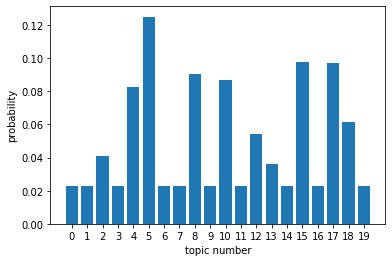

In [7]:
scores = [full_probmaps[i]['chinesevirus'] for i in range(total_topics)]

plt.bar(range(total_topics), scores)
plt.xticks(range(total_topics))
plt.ylabel('probability')
plt.xlabel('topic number')

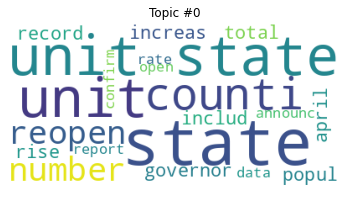

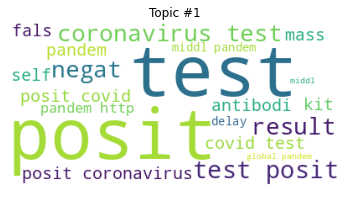

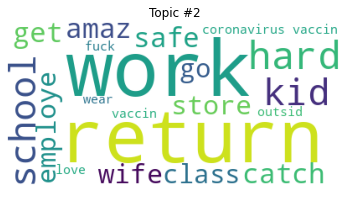

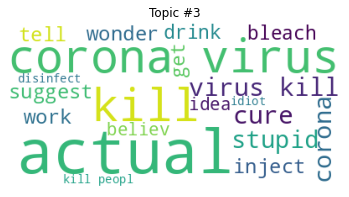

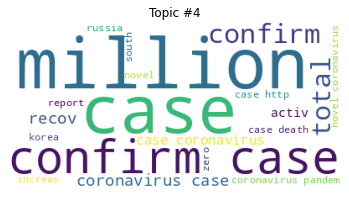

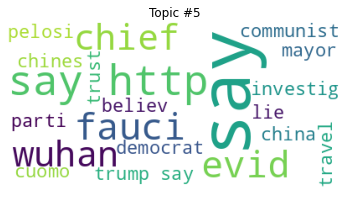

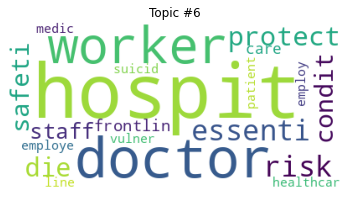

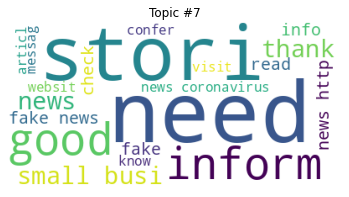

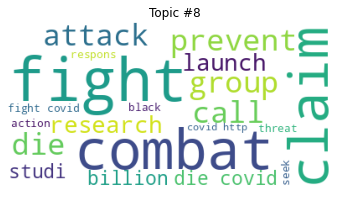

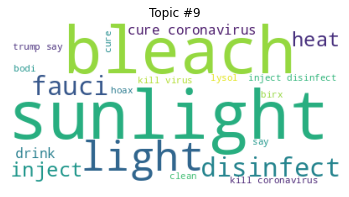

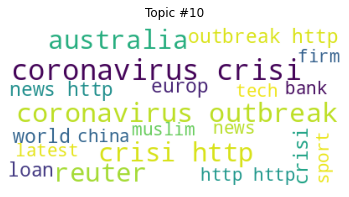

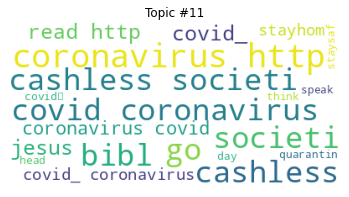

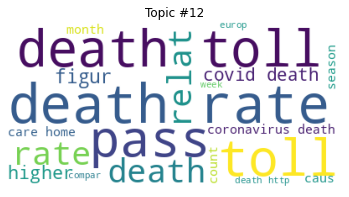

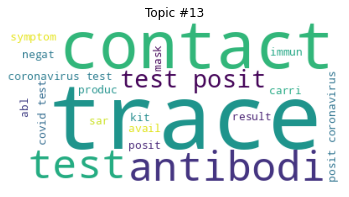

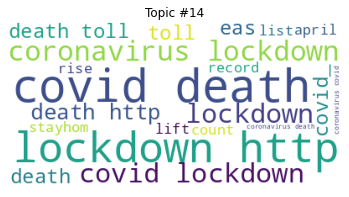

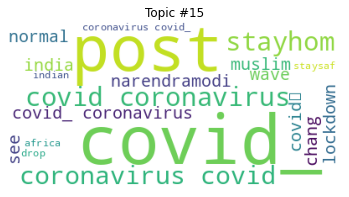

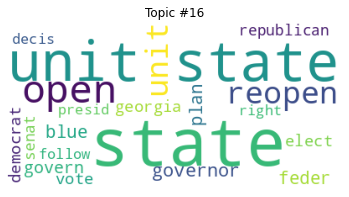

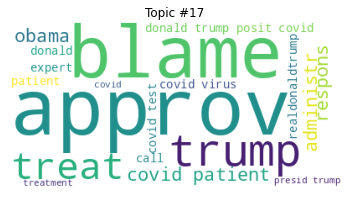

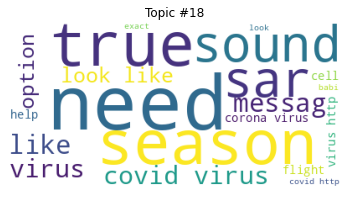

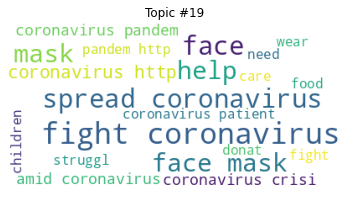

In [13]:
# draw word clouds

for t in range(total_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(top20probmaps[t]))
    plt.axis("off")
    plt.title("Topic #" + str(t))